## Part 1: Working with data in `PyTorch`
<a id=part1></a>

In this part, we'll learn about the `Dataset` and `DataLoader` classes which are part of `PyTorch`'s `torch.util.data` package.
These are highly useful abstractions that can greatly reduce the amount of boilerplate code you need to write in order to work with data.
Knowing how to use these classes properly will prove useful in the coming assignments and course project.

In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import unittest

%matplotlib inline
%load_ext autoreload
%autoreload 2

plt.rcParams.update({'font.size': 12})
torch.random.manual_seed(1904)
test = unittest.TestCase()

### Datasets
<a id=part1_1></a>

The `Dataset` class is an abstraction over a sequence of python objects,
each representing a sample (with or without a label). it's main purpose is
to load a single (possibly labeled) sample from some soure (disk, web, etc) into memory,
and transform it into a usuable representation (e.g. image to tensor).

The `Dataset` abstracts away exactly when the data is loaded into memory: It can be on
demand when each sample is accessed, all in advance or some combination using e.g. caching.
This is implementation-specific.

Lets create a demonstration `Dataset` that returns noise images. It should:
- Return random tensors of size `CxWxH`.
- Label each returned tensor with a class label, an integer between `0` and `num_classes-1`.
- Initialize each returned tensor with a uniform distribution on `[0, 255]`.
- Return a total of `num_samples` labeled images.

**TODO** Implement the `RandomImageDataset` class in the `hw1/datasets.py` module.
Use the code below to test your implementation.

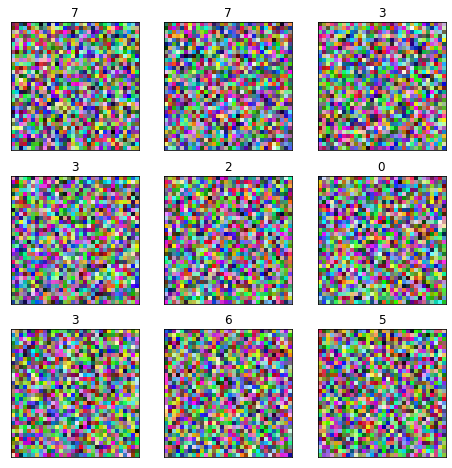

In [2]:
# Test RandomImageDataset
import cs236781.plot as plot
import hw1.datasets as hw1datasets

# Create the dataset
num_samples = 1000
num_classes = 10
image_size = (3, 32, 32)
ds = hw1datasets.RandomImageDataset(num_samples, num_classes, *image_size)

# You can load individual items from the dataset by indexing
img0, cls0 = ds[0]

# Plot first N images from the dataset with a helper function
fig, axes = plot.dataset_first_n(ds, 9, show_classes=True, nrows=3)

### Built-in Datasets and Transforms
<a id=part1_2></a>

Now that we've created a simple `Dataset` to see how they work, we'll load one of `pytorch`'s built-in datasets: CIFAR-10. This is a famous dataset consisting of 60,000 small `32x32` color images classified into 10 classes. You can read more about it [here](https://www.cs.toronto.edu/~kriz/cifar.html).

The `torchvision` package has built-in `Dataset` classes that can download the data to a local folder,
load it, transform it using arbitrary transform functions and iterate over the resulting samples.

Run the following code block to download and create a CIFAR-10 `Dataset`. It won't be downloaded again if already present.

Now that we've loaded the entire CIFAR-10 dataset, we would want to work with a smaller subset
from it to reduce runtime of the code in this notebook.
A simple way to achieve this with `Datasets` is to wrap a `Dataset` in another `Dataset` that does this for us. This will make it easy to use our subset with `DataLoader`s as you will see later.

Run the following block to download CIFAR-10 and plot some random images from it.

Files already downloaded and verified
Number of samples: 50000


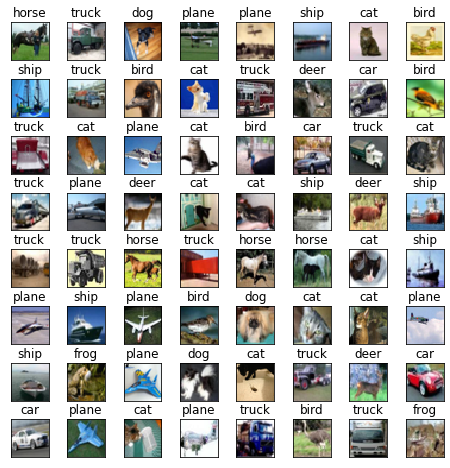

In [3]:
import os
import torchvision
import torchvision.transforms as tvtf

cfar10_labels = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
data_root = os.path.expanduser('~/.pytorch-datasets')

cifar10_train_ds = torchvision.datasets.CIFAR10(
    root=data_root, download=True, train=True,
    transform=tvtf.ToTensor()
)

print('Number of samples:', len(cifar10_train_ds))

# Plot them with a helper function
fig, axes = plot.dataset_first_n(cifar10_train_ds, 64,
                                 show_classes=True, class_labels=cfar10_labels,
                                 nrows=8, hspace=0.5)

Now, let's say we would like to only work with a small subset of the CIFAR-10 dataset.
One way to easily achieve this is to wrap the built-in `Dataset` object with a custom dataset that exposes a different number of samples.

**TODO** Complete the implementation of `SubsetDataset` in `hw1/datasets.py` and use the following code block to test.

In [4]:
subset_len = 5000
subset_offset = 1234
cifar10_train_subset_ds = hw1datasets.SubsetDataset(cifar10_train_ds, subset_len, subset_offset)

dataset_x, dataset_y  = cifar10_train_ds[subset_offset + 10]
subset_x, subset_y  = cifar10_train_subset_ds[10]

# Tests
test.assertEqual(len(cifar10_train_subset_ds), subset_len)
test.assertTrue(torch.all(dataset_x == subset_x))
test.assertEqual(dataset_y, subset_y)
with test.assertRaises(IndexError, msg="Out of bounds index should raise IndexError"):
    tmp = cifar10_train_subset_ds[subset_len]

Notice that when we initialized the `Dataset` instance for CIFAR-10, we provided a `transform` parameter.
This is a way to specify an arbitrary transformation that should be run on each sample prior to returning it from the dataset.

In the above, we used the `ToTensor()` transformation from `torchvision.transforms` to convert the
images from a PIL (Python Imaging Library) image object which has a shape of `32x32x3` and values in range \[0, 255\] into a pytorch `Tensor` of shape `3x32x32` and values in range \[0, 1\].

To demonstrate the use of transforms, we'll implement two custom transforms which invert the colors and flip the images along the height axis.

**TODO** Complete the `InvertColors` and `FlipUpDown` classes in the `hw1/transforms.py` module.

Files already downloaded and verified


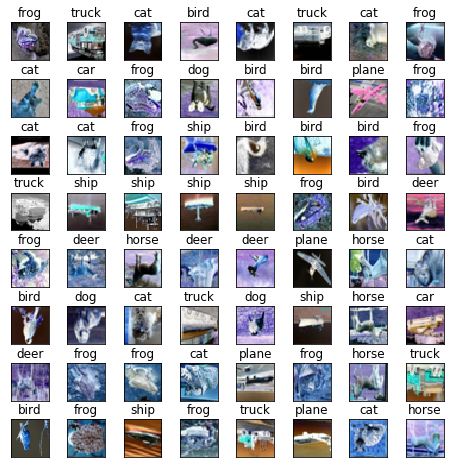

In [5]:
import hw1.transforms as hw1transforms

cifar10_inverted_ds = torchvision.datasets.CIFAR10(
    root=data_root, download=True, train=True,
    transform=tvtf.Compose([ # Compuse allows us to chain multiple transforms in a sequence
        tvtf.ToTensor(), # Convert PIL image to pytorch Tensor (C,H,W) in range [0,1]
        hw1transforms.InvertColors(),
        hw1transforms.FlipUpDown(),
    ])
)

fig, axes = plot.dataset_first_n(cifar10_inverted_ds, 64,
                                 show_classes=True, class_labels=cfar10_labels,
                                 nrows=8, hspace=0.5)

test.assertTrue(torch.allclose(cifar10_train_ds[0][0], torch.flip(1.-cifar10_inverted_ds[0][0], [1])),
               "Wrong custom transform")

### `DataLoader`s and `Sampler`s
<a id=part1_3></a>

We have seen that a `Dataset` is simply an iterable returning samples by index.
Simple to implement, but not very powerful.
The real benefit is when combining them with `DataLoader`.
A `DataLoader` samples a batch of samples from the dataset according to logic defined by a `Sampler` object.
The sampler decides how to partition the dataset into batches of `N` samples.
The `DataLoader` additionally handles loading samples in parallel to speed up creation of a batch.

A major motivation here is memory usage. When combining a `DataLoader` with a `Dataset` we can easily
control memory constraints by simply setting the batch size. This is important since large
datasets (e.g. ImageNet) may not fit in memory of most machines.
Since a `Dataset` can lazily load samples from disk on access,
and the `DataLoader` can sample random samples from it in parallel, we are provided with a simple
yet high-performance mechanism to iterate over random batches from our dataset without needing to
hold all of it in memory.

Let's create a basic `DataLoader` for our CIFAR-10 dataset.
Run the follwing code block multiple times and observe that different samples are shown each time in the first few batches.

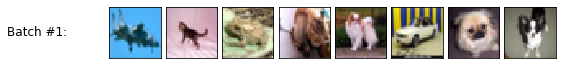

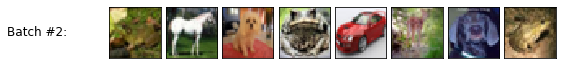

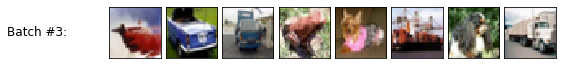

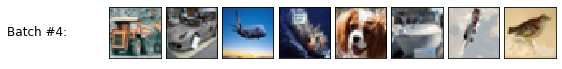

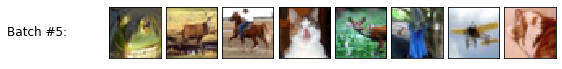

In [6]:
# Create a simple DataLoader that partitions the data into batches
# of size N=8 in random order, using two background proceses
cifar10_train_dl = torch.utils.data.DataLoader(
    cifar10_train_ds, batch_size=8, shuffle=True, num_workers=2
)

# Iterate over batches sampled with our DataLoader
num_batches_to_show = 5
for idx, (images, classes) in enumerate(cifar10_train_dl):
    # The DataLoader returns a tuple of:
    # images: Tensor of size NxCxWxH
    # classes: Tensor of size N
    fig, axes = plot.tensors_as_images(images, figsize=(8, 1))
    fig.suptitle(f'Batch #{idx+1}:', x=0, y=0.6)
    if idx >= num_batches_to_show - 1:
        break

### Training, Validation and Test Sets
<a id=part1_4></a>

Now that we know about `DataLoaders` we can use them to do something useful: split a training dataset into **Training and Validation** sets.

A common issue with machine learning models is abundance of hyperparameters that must be selected prior to training the model on data. More generally, multiple different models, or hypothesis classes could be fitted to the data.
We would like to determine which model and/or hyperparameter selection of the same model can best fit the training data we have.

How are such hyperparameters selected? How should their fitness be evaluated?
While tempting, we can't use our test dataset to determine this. Doing so would be effectively equivalent to training with the test set, and may significantly bias our model towards overfitting, reducing it's generalization ability.

A prevalent approach is therefore to split the training dataset into two parts:
One for actual training, i.e. tuning model parameters e.g. weights in the case of neural nets,
and another for validation, i.e. comparing one model or set of hyperparameters to another.
After the best model is selected (by seeking the minimal validation error), it can be retrained with the entire training set.

Crucially, test set performance is only evaluated once, at the end, after the best model has been selected and trained on the full training set. This provides us with an unbiased estimate of how our model will generalize to previously-unseen data.

![img](https://cdn-images-1.medium.com/max/1600/1*Nv2NNALuokZEcV6hYEHdGA.png)

**TODO** Implement the function `create_train_validation_loaders` in the `hw1/dataloaders.py` module.
Use the following code block to check your implementation.

In [7]:
# Testing the train/validation split dataloaders
import hw1.dataloaders as hw1dataloaders

validation_ratio = 0.2
dl_train, dl_valid = hw1dataloaders.create_train_validation_loaders(cifar10_train_ds, validation_ratio)

train_idx = set(dl_train.sampler.indices)
valid_idx = set(dl_valid.sampler.indices)
train_size = len(train_idx)
valid_size = len(valid_idx)
print('Training set size: ', train_size)
print('Validation set size: ', valid_size)

# Tests
test.assertEqual(train_size+valid_size, len(cifar10_train_ds), "Incorrect total number of samples")
test.assertEqual(valid_size, validation_ratio * (train_size + valid_size), "Incorrect ratio")
test.assertTrue(train_idx.isdisjoint(valid_idx), "Train and validation sets are not disjoint")

Training set size:  40000
Validation set size:  10000
